In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


In [2]:
#Class Labels
labels_ = [ 
            'Speed limit (30km/h)', 
            'Speed limit (50km/h)', 
            'Speed limit (120km/h)', 
            'No passing', 
            'No passing veh over 3.5 tons', 
            'Priority road', 
            'Yield', 
            'Stop', 
            'No entry', 
            'Turn right ahead', 
            'Turn left ahead', 
            'Go straight or right', 
            'Go straight or left', 
]

In [3]:
#Defining function for plotting confusion matrix with Seaborn library
from sklearn.metrics import confusion_matrix

def conf_matrix(pred_labels, y_test):
    conf_mat = confusion_matrix(y_test,pred_labels)
    fig, ax = plt.subplots(figsize=(20,15))
    sn.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels_, yticklabels=labels_)
    plt.ylabel('Actual') 
    plt.yticks(rotation=0) 
    plt.xlabel('Predicted')
    plt.show()

In [4]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.11.0 CUDA: True


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:

# manual seed to reproduce same results

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [7]:
image_size = (32,32)

transformations = transforms.Compose(
        [transforms.Resize(list(image_size)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])])

In [10]:
batch_size = 128 

train_set = datasets.ImageFolder('Train', transform = transformations)
# YOUR CODE HERE for the DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, worker_init_fn=seed_worker, generator=g)

In [11]:
d = 0
for (a,b) in train_loader:
    d+= 1
    if(d<10):
       
        print(a)

RuntimeError: DataLoader worker (pid(s) 3572) exited unexpectedly

In [ ]:
# Get input/output from data loader
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([130, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([130]) type: torch.LongTensor


In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # Dropout to avoid overfitting
        self.drop_out = nn.Dropout()

        # Fully connected layers
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 13)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # Flatten
        out = out.view(out.size(0), -1)

        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
# Declaring the loss function and optimizer

model = CNN()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [ ]:
d = 0
for batch_idx, (data, target) in enumerate(train_loader):
    
    print(batch_idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132


In [ ]:
# YOUR CODE HERE. This will take time

# Record loss and accuracy of the train dataset
def train(epoch, log_interval=100):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.float())
        target = Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == target).sum().item()        

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), (correct / total) * 100))

In [ ]:
%%time
epochs = 6
lossv, accv = [], []
for epoch in range(1, epochs+1):
    train(epoch)
    # test(lossv, accv)

Train Epoch: 1 [0/17219 (0%)]	Loss: 2.668890	Accuracy: 8.46%
Train Epoch: 1 [13000/17219 (75%)]	Loss: 0.406327	Accuracy: 86.15%
Train Epoch: 2 [0/17219 (0%)]	Loss: 0.410029	Accuracy: 85.38%
Train Epoch: 2 [13000/17219 (75%)]	Loss: 0.206654	Accuracy: 93.85%
Train Epoch: 3 [0/17219 (0%)]	Loss: 0.103925	Accuracy: 96.15%
Train Epoch: 3 [13000/17219 (75%)]	Loss: 0.179219	Accuracy: 95.38%
Train Epoch: 4 [0/17219 (0%)]	Loss: 0.075231	Accuracy: 97.69%
Train Epoch: 4 [13000/17219 (75%)]	Loss: 0.087690	Accuracy: 97.69%
Train Epoch: 5 [0/17219 (0%)]	Loss: 0.039224	Accuracy: 99.23%
Train Epoch: 5 [13000/17219 (75%)]	Loss: 0.077580	Accuracy: 96.92%
Train Epoch: 6 [0/17219 (0%)]	Loss: 0.033322	Accuracy: 99.23%
Train Epoch: 6 [13000/17219 (75%)]	Loss: 0.042578	Accuracy: 100.00%
CPU times: total: 13.7 s
Wall time: 1min 59s


In [ ]:
torch.save(model.state_dict(), 'conv_net_model.ckpt')

In [ ]:
# Load the model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('conv_net_model.ckpt',map_location=device))
loaded_model.eval()


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [ ]:
# Testing Evaluation for CNN model

val_set = datasets.ImageFolder('Test',transform = transformations)

# YOUR CODE HERE for the DataLoader
test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
# Get input/output from data loader
for (X_test, y_test) in test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break

X_test: torch.Size([130, 3, 32, 32]) type: torch.FloatTensor
y_test: torch.Size([130]) type: torch.LongTensor


In [ ]:
# YOUR CODE HERE for calculating the accuracy
loaded_model.eval()

loaded_model = model.eval()

correct = 0
total = 0

#Initalize empty tensor for storing predictions
predicted_np = torch.empty(0)

#Initialize empty tensor for storing labels from test data
test_labels_np = torch.empty(0)

#Transfer empty tensor to "device" (to CUDA if necesaary)
predicted_np , test_labels_np = predicted_np.to(device), test_labels_np.to(device)

for images, labels in test_loader:
    images = Variable(images.float())
    images, labels = images.to(device), labels.to(device)
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted_np = torch.concat((predicted_np,predicted))
    test_labels_np = torch.concat((test_labels_np,labels))
    total += labels.size(0)
    correct += (predicted == labels).sum()

#Transfer tensors with label, to cpu and convert to numpy arrays for further processings.
predicted_np = predicted_np.cpu().numpy()
test_labels_np = test_labels_np.cpu().detach().numpy()
print('Test Accuracy of the model on test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on test images: 97.5936 %


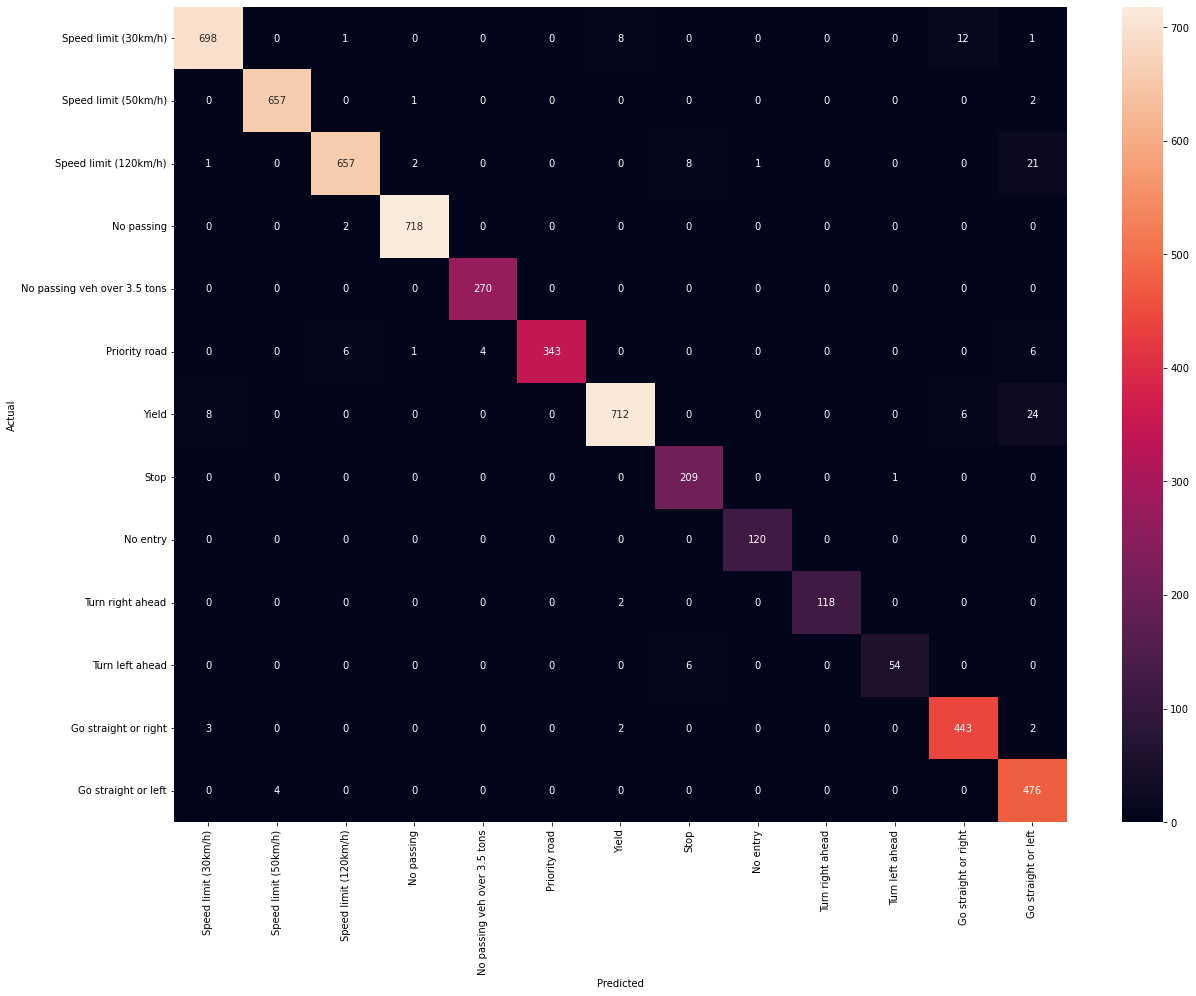

In [ ]:
conf_matrix(predicted_np,test_labels_np)

In [ ]:
import torch
  
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device:GeForce GTX 1050 Ti


In [ ]:
torch.backends.cudnn.version()

8200